In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.version

import yfinance as yf
yf.pdr_override()
import pandas as pd
from matplotlib import pyplot as plt

'3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]'

In [4]:
def get_stock(symbol, start, end):
    stocks = yf.download("SPX " + symbol, start, end)
    assert (len(stocks.columns) > 1), "Could not find symbol " + symbol
    return stocks['Adj Close'][[symbol]]

In [5]:
def timing_experiment(symbol, measured_days, step_size, trials = None):
    from collections import defaultdict
    import math

    assert isinstance(symbol, pd.DataFrame), "DataFrame is required for input"
    assert len(symbol.columns) == 1, "Can only support one symbol at a time."
    # assert isinstance(start_date, str)
    # assert isinstance(end_date, str)
    assert isinstance(measured_days, int)
    assert isinstance(step_size, int)

    #start and end dates need to be on a trading day
    start_date = '2012-01-06'
    end_date = '2021-01-29'
    max_end_date = str((symbol.index[len(symbol)-measured_days]).date())
    tests = defaultdict(list)

    if trials == None:
        trials = math.floor((len(symbol)-measured_days)/step_size)
        print("Trials not specified. Using maximum allowed trials: " + str(trials))
    elif trials > (len(symbol)-measured_days)/step_size:
        trials = math.floor((len(symbol)-measured_days)/step_size)
        print("Trials exceed maximum allowed. Using maximum allowed trials: " + str(trials))
        
    for i in range(0,trials):
        time_frame = symbol.iloc[0+i*step_size:measured_days+i*step_size,0].reset_index()
        values = time_frame.iloc[:,1]
        key_name = str(time_frame.iloc[0,0].date())
        test = values/values[0] - 1
        tests[key_name] = test
    return pd.DataFrame(tests)

[*********************100%***********************]  2 of 2 completed
Trials not specified. Using maximum allowed trials: 222


<AxesSubplot:>

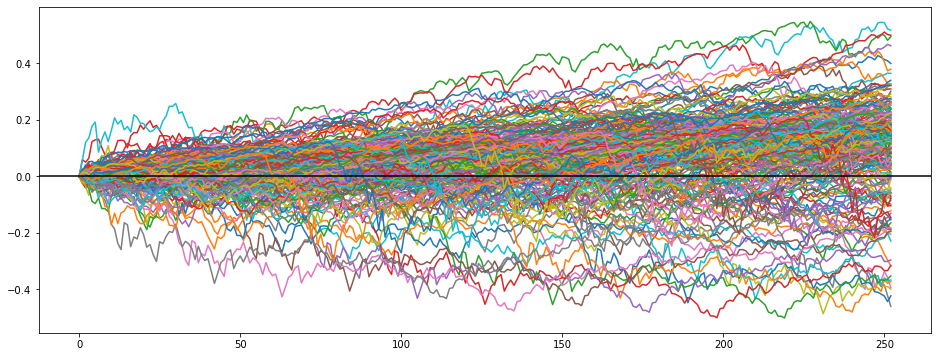

In [6]:
symbols = get_stock('VTI', '2001-06-15', '2021-01-06')
symbol = symbols.loc[symbols.first_valid_index():]
result = timing_experiment(
    symbol = symbol,
    measured_days = 253,
    step_size = 21
    )
    
result.plot(figsize=(16,6), legend = False)
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

<AxesSubplot:>

Test period: 2001-06-15 to 2019-11-26
Time in market: ~    1 years
Average return:     9.80 percent
Misc. Summary
std    16.712159
min   -46.023361
25%     2.982713
50%    13.054964
75%    19.757924
max    51.648929
Name: 252, dtype: float64
Loss ratio:    44 out of   222 (   19.82 percent)


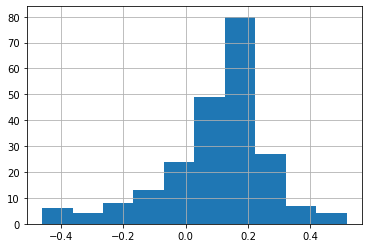

In [7]:
end_values = result.iloc[len(result)-1]
loss_count = len(end_values[end_values <= 0])

end_values.hist(bins = 10)

avg_return = end_values.mean()*100
print("Test period: %s to %s" % (result.columns[0],
    result.columns[len(result.columns)-1]))
print("Time in market: ~%5d years" % (len(result)/253))
print("Average return: %8.2f percent" % (avg_return))
print("Misc. Summary")
print(end_values.describe()[2:8]*100)
print("Loss ratio: %5d out of %5d (%8.2f percent)" % (loss_count, len(end_values), loss_count*100/len(end_values)))

In [6]:
#barplot the number of ITM/OTM positions over each time period